# Cork Simulation Notebook

Welcome to the **Cork Simulation Notebook**! This notebook allows you to simulate a cork environment with agents and tokens, and visualize the results with informative charts.

## Table of Contents

1. [Introduction](#Introduction)
2. [Prerequisites](#Prerequisites)
3. [Generate Event Data](#Generate-Event-Data)
4. [Setup](#Setup)
   - [Importing Libraries](#Importing-Libraries)
   - [Defining Configuration Parameters](#Defining-Configuration-Parameters)
5. [Initializing the Blockchain](#Initializing-the-Blockchain)
6. [Adding Tokens and Agents](#Adding-Tokens-and-Agents)
7. [Running the Simulation](#Running-the-Simulation)
8. [Analyzing Results](#Analyzing-Results)
   - [Agent Wallet Face Value Over Time](#Agent-Wallet-Face-Value-Over-Time)
   - [Token Prices Over Time](#Token-Prices-Over-Time)
   - [Vault LP Token Price Over Time](#Vault-LP-Token-Price-Over-Time)
   - [AMM Reserves Over Time](#AMM-Reserves-Over-Time)
   - [Borrowed ETH Over Time](#Borrowed-ETH-Over-Time)
   - [Borrowed Tokens Over Time](#Borrowed-Tokens-Over-Time)
9. [Conclusion](#Conclusion)


## Introduction

This notebook simulates a blockchain environment where agents interact with tokens, the cork protocol and automated market makers (AMMs). The simulation collects various statistics during each block and visualizes them to help you understand the dynamics of the blockchain, agents, and tokens.

**Key Components:**

- **Blockchain:** Manages blocks, tokens, agents, and statistics.
- **Agents:** Entities that perform actions in the blockchain (e.g., buying tokens).
- **Tokens:** Digital assets that agents can interact with.
- **AMMs:** Automated Market Makers that facilitate token swaps.
- **Vaults and PSMs:** The cork protocol


## Prerequisites

Before we begin, ensure you have the following:

- **Python 3.7 or higher**
- **Jupyter Notebook or JupyterLab**
- Required Python packages:
  - `pandas`
  - `matplotlib`
  - `seaborn`
  - `colorama`

## Generate Event Data

The `generate_events.py` script connects to the CoinGecko API to download daily prices of **stETH (Lido Staked Ether)** and **ETH (Ethereum)** within a specified date range. It analyzes the stETH/ETH price ratio to identify **depeg** events when the ratio falls below a defined threshold and **repeg** events when it returns to the peg.

### How to Use the Command

Run the script from your command line with the following parameters:

- **Start Date** (`--start-date`): The beginning date for data analysis in `YYYY-MM-DD` format. *(Required)*
- **End Date** (`--end-date`): The ending date for data analysis in `YYYY-MM-DD` format. *(Required)*
- **Threshold** (`--threshold`): The depeg threshold as a decimal (e.g., `0.05` for 5%). *(Optional; default is `0.05`)*
- **Output File** (`--output`): The name of the output JSON file. *(Optional; default is `events.json`)*
- **Token Symbol** (`--token-symbol`): The symbol of the token (default is `stETH`). *(Optional)*
- **CoinGecko ID** (`--coin-gecko-id`): The CoinGecko ID for stETH (default is `steth`). *(Optional)*
- **VS Currency** (`--vs-currency`): The currency to compare against (default is `eth`). *(Optional)*
- **API Key** (`--api-key`): Required for the paid plan, especially for historical data > 1y. *(Optional)*

**Example Command:**

To generate `events.json` with a 5% depeg threshold from January 1, 2024, to October 26, 2024 - this command wouldn't create events because there wasn't a 5% depeg in that timeframe :):

```bash
python generate-events.py \
  --start-date 2024-01-01 \
  --end-date 2024-10-26 \
  --threshold 0.05 \
  --output events.json \
  --token-symbol stETH \
  --coin-gecko-id staked-ether \
  --vs-currency eth
```

## Setup

In [1]:
# Install required packages if not already installed
# Uncomment the lines below if you need to install the packages

# !pip install pandas matplotlib seaborn colorama numpy requests 

# Import standard libraries
import random
import copy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import widgets for interactivity
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown

# Import custom modules
from agents.insurer import Insurer
from agents.lst_maximalist import LstMaximalist
from agents.ct_long_term import CTLongTermAgent
from agents.ct_speculation import CTShortTermAgent
from agents.ds_long_term import DSLongTermAgent
from agents.ds_speculation import DSShortTermAgent
from agents.redemption_arbitrage import RedemptionArbitrageAgent
from agents.repurchase_arbitrage import RepurchaseArbitrageAgent
from agents.lv_depositor import LVDepositorAgent
from agents.looping import LoopingAgent
from simulator.blockchain import Blockchain
from simulator.amm import UniswapV2AMM, YieldSpaceAMM

# Set plotting style
sns.set_style('whitegrid')

# Enable inline plotting for Jupyter
%matplotlib inline

### Defining Configuration Parameters

In this section, we'll define the simulation parameters. You can adjust these parameters to see how they affect the simulation.


In [2]:
# Simulation parameters
NUM_BLOCKS = 300  # Number of blocks to simulate
INITIAL_ETH_BALANCE = 100.0  # Initial ETH balance for each agent
PSM_EXPIRY_AFTER_BLOCK = 300  # Block after which the Peg Stability Module (PSM) expires

# Token parameters
TOKEN_NAME = 'stETH'  # Name of the token to simulate
INITIAL_AGENT_TOKEN_BALANCE = 100.0  # Initial token balance for each agent
AMM_RESERVE_ETH = 1000000.0  # Initial ETH reserve in the AMM
AMM_RESERVE_TOKEN = 1000000.0  # Initial token reserve in the AMM
AMM_FEE = 0.00  # Fee percentage in the AMM
INITIAL_YIELD_PER_BLOCK = 0.03 / 365  # Yield per block (assuming 3% annual yield)
PSM_REDEMPTION_FEES = 0.001  # Redemption fees for the Peg Stability Module
PSM_REPURCHASE_FEES = 0.05  # Reurchase fees for the Peg Stability Module

# Agents to include in the simulation
AGENT_NAMES = [
    #'LstMaximalist',
    #'Insurer',
    'DSShortTerm',
    'CTShortTerm',
    'DSLongTerm',
    'CTLongTerm',
    'RedemptionArbitrage',
    'RepurchaseArbitrage',
    'LVDepositor',
    #'LoopingAgent'
    ]

## Initializing the Blockchain

Now we'll create the blockchain instance using the parameters defined above.


In [3]:
# Create the blockchain
chain = Blockchain(
    num_blocks=NUM_BLOCKS,
    initial_eth_balance=INITIAL_ETH_BALANCE,
    psm_expiry_after_block=PSM_EXPIRY_AFTER_BLOCK
)

## Adding Tokens and Agents

### Adding the Token

We'll add a token to the blockchain with its associated AMM.


In [4]:
# Add the token with the specified AMM
chain.add_token(
    token=TOKEN_NAME,
    risk=0.02,
    initial_agent_balance=INITIAL_AGENT_TOKEN_BALANCE,
    amm=UniswapV2AMM(
        token_symbol=TOKEN_NAME,
        reserve_eth=AMM_RESERVE_ETH,
        reserve_token=AMM_RESERVE_TOKEN,
        fee=AMM_FEE
    ),
    initial_yield_per_block=INITIAL_YIELD_PER_BLOCK
)

### Adding Agents

We'll instantiate the agents and add them to the blockchain.


In [5]:
# Instantiate agents based on AGENT_NAMES
agents = []
for name in AGENT_NAMES:
    #if name == 'LstMaximalist':
    #    agents.append(LstMaximalist(TOKEN_NAME))
    #elif name == 'Insurer':
    #    agents.append(Insurer(TOKEN_NAME))
    if name == 'DSShortTerm':
        agents.append(DSShortTermAgent(name="DS Short Term", token_symbol=TOKEN_NAME, threshold=0.01))
    elif name == 'CTShortTerm':
        agents.append(CTShortTermAgent(name="CT Short Term", token_symbol=TOKEN_NAME, buying_pressure=10))
    elif name == 'DSLongTerm':  
        agents.append(DSLongTermAgent(name="DS Long Term", token_symbol=TOKEN_NAME, buying_pressure=1))
    elif name == 'CTLongTerm':
        agents.append(CTLongTermAgent(name="CT Long Term", token_symbol=TOKEN_NAME, percentage_threshold=0.01))
    elif name == 'RedemptionArbitrage':
        agents.append(RedemptionArbitrageAgent(name="Redemption Arb", token_symbol=TOKEN_NAME))
    elif name == 'RepurchaseArbitrage':
        agents.append(RepurchaseArbitrageAgent(name="Repurchase Arb", token_symbol=TOKEN_NAME))
    elif name == 'LVDepositor':
        agents.append(LVDepositorAgent(name="LV Depositor", token_symbol=TOKEN_NAME, expected_apy=0.05))
    elif name == 'LoopingAgent':
        agents.append(LoopingAgent(
            name="Looping Agent", 
            token_symbol=TOKEN_NAME,
            initial_borrow_rate=0.001, 
            borrow_rate_changes={}, 
            max_ltv=0.7, 
            lltv=0.915))

# Add agents to the blockchain
chain.add_agents(*agents)


## Running the Simulation

Now we'll start the mining process, which runs the simulation over the specified number of blocks.


In [6]:
# Start mining without printing stats to minimize output
chain.start_mining(print_stats=False)

## Analyzing Results

After the simulation, we can analyze the collected statistics and visualize them using charts.


In [7]:
# Access stats dataframes
agents_stats = chain.stats['agents']
tokens_stats = chain.stats['tokens']
vaults_stats = chain.stats['vaults']
amms_stats = chain.stats['amms']
borrowed_eth_stats = chain.stats['borrowed_eth']
borrowed_tokens_stats = chain.stats['borrowed_tokens']


### Agent Wallet Face Value Over Time

Let's visualize how the wallet face value of each agent changes over time.


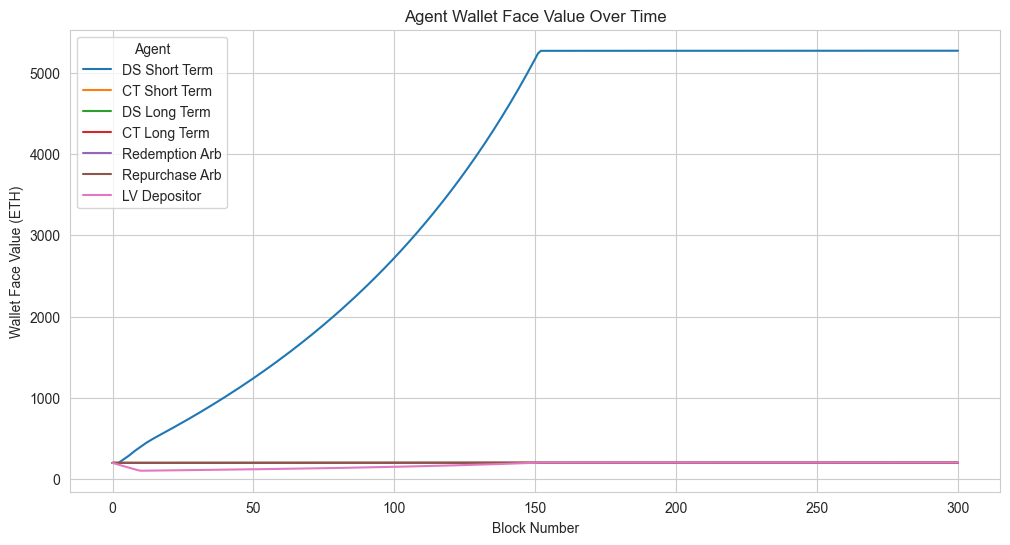

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=agents_stats,
    x='block',
    y='wallet_face_value',
    hue='agent',
)
plt.title('Agent Wallet Face Value Over Time')
plt.xlabel('Block Number')
plt.ylabel('Wallet Face Value (ETH)')
plt.legend(title='Agent')
plt.grid(True)
plt.show()

# Single Agent Walkthroughs

Let's validate all agents take action according to the triggers and reasoning specified

In [9]:
all_trades = pd.DataFrame(chain.all_trades)

In [10]:
(
    all_trades
    .groupby(['agent', 'action'])
    .agg(
        Total_Actions=('action', 'count'),
        Total_Volume_in_ETH=('volume', 'sum')
)
)

,,Total_Actions,Total_Volume_in_ETH
agent,action,,
CT Short Term,sell,298,0.0
DS Short Term,buy,150,100.0


We can see that all Agents take some actions (with differing volumes). Let's investigate in more detail on a per agent level.

## DS Speculation

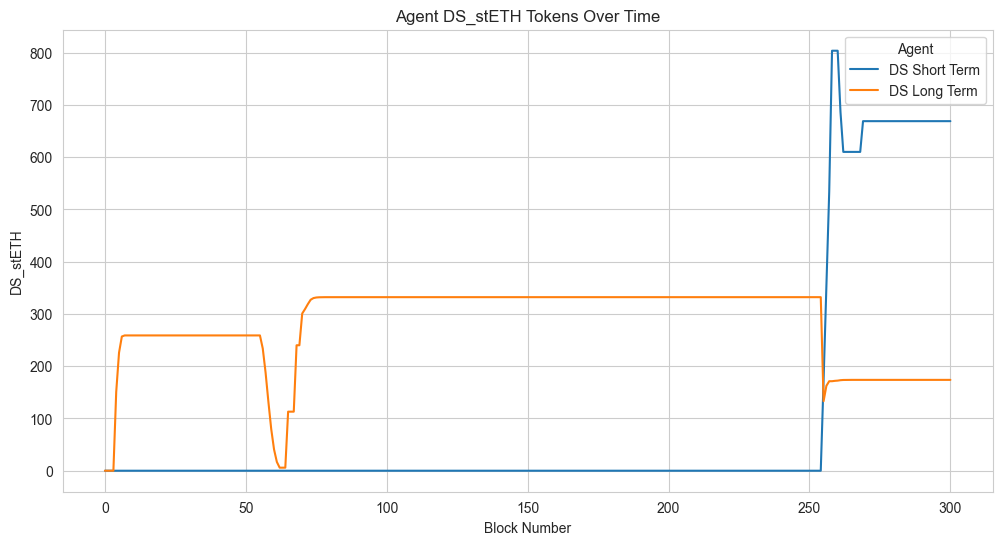

In [14]:
agents = ['DS Long Term', 'DS Short Term']


plt.figure(figsize=(12, 6))
sns.lineplot(
    data=pd.concat([
        agents_stats.query("agent in @agents")[["agent","block"]],
        agents_stats.query("agent in @agents")["wallet_token_balances"].apply(pd.Series)
    ], axis=1),
    x='block',
    y='DS_stETH',
    hue='agent',
)
plt.title('Agent DS_stETH Tokens Over Time')
plt.xlabel('Block Number')
plt.ylabel('DS_stETH')
plt.legend(title='Agent')
plt.grid(True)
plt.show()

In [15]:
current_agent = "DS Short Term"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
)

,block,agent,token,volume,action,reason,arp,ewa_slope,arp_history
1065,255,DS Short Term,DS,12.844327,buy,sharp decline,0.378399,-0.010273,"[-0.07534246575342467, -0.07564277828292998, -..."
1072,256,DS Short Term,DS,13.394257,buy,sharp decline,0.366808,-0.010713,"[-0.07534246575342467, -0.07564277828292998, -..."
1076,257,DS Short Term,DS,13.980339,buy,sharp decline,0.354690,-0.011181,"[-0.07534246575342467, -0.07564277828292998, -..."
1083,258,DS Short Term,DS,59.781076,buy,sharp decline,-0.167889,-0.171083,"[-0.07534246575342467, -0.07564277828292998, -..."
1108,261,DS Short Term,DS,1617.560552,sell,sharp incline,0.356159,0.085051,"[-0.07534246575342467, -0.07564277828292998, -..."
1110,262,DS Short Term,DS,1051.832006,sell,sharp incline,0.342214,0.055305,"[-0.07534246575342467, -0.07564277828292998, -..."
1120,263,DS Short Term,DS,651.562600,sell,sharp incline,0.327536,0.034259,"[-0.07534246575342467, -0.07564277828292998, -..."
1123,264,DS Short Term,DS,366.767581,sell,sharp incline,0.312064,0.019285,"[-0.07534246575342467, -0.07564277828292998, -..."
1152,269,DS Short Term,DS,3.986148,buy,sharp decline,0.220199,-0.011480,"[-0.07534246575342467, -0.07564277828292998, -..."


## DS Long Term

In [29]:
current_agent = "DS Long Term"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
)

,block,agent,token,volume,action,reason,buying_intent,ds_price,lst_yield_per_block,lst_price,depeg_threshold,extended_depeg_increase
0,1,DS Long Term,DS,1.561252e-07,buy,buying_intent,1.561252e-09,0.1,0.024658,NaN,NaN,NaN
2,2,DS Long Term,DS,1.561253e-07,buy,buying_intent,1.561253e-09,0.1,0.024658,NaN,NaN,NaN
4,3,DS Long Term,DS,1.561253e-07,buy,buying_intent,1.561253e-09,0.1,0.024658,NaN,NaN,NaN
6,4,DS Long Term,DS,1.888756e+01,buy,buying_intent,1.888756e-01,0.1,0.300000,NaN,NaN,NaN
8,5,DS Long Term,DS,1.532016e+01,buy,buying_intent,1.888757e-01,0.1,0.300000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
551,296,DS Long Term,DS,1.191572e-12,buy,buying_intent,5.737543e-01,0.1,0.900000,NaN,NaN,NaN
552,297,DS Long Term,DS,5.079025e-13,buy,buying_intent,5.737543e-01,0.1,0.900000,NaN,NaN,NaN
563,298,DS Long Term,DS,2.164913e-13,buy,buying_intent,5.737543e-01,0.1,0.900000,NaN,NaN,NaN
568,299,DS Long Term,DS,9.227848e-14,buy,buying_intent,5.737543e-01,0.1,0.900000,NaN,NaN,NaN


## CT Short Term

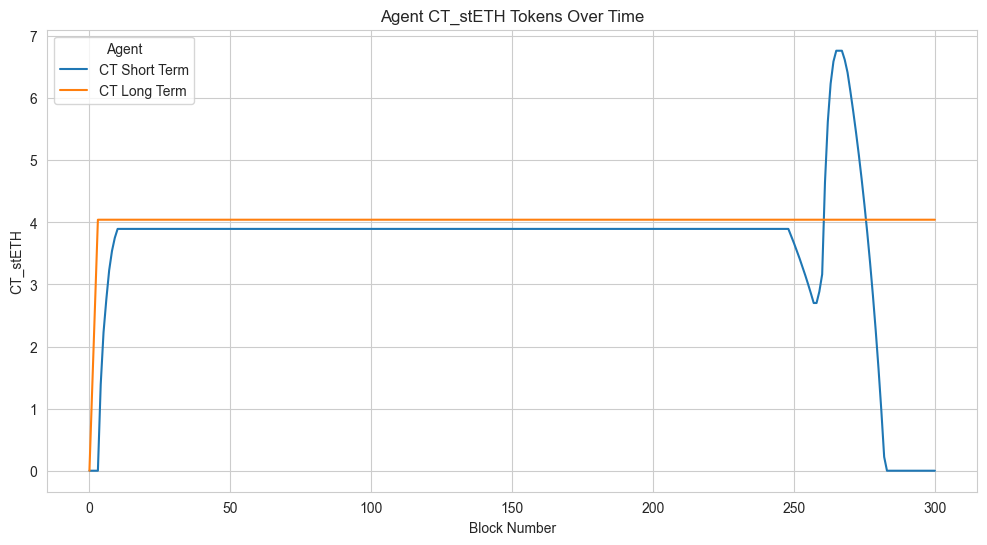

In [30]:
agents = ['CT Long Term', 'CT Short Term']


plt.figure(figsize=(12, 6))
sns.lineplot(
    data=pd.concat([
        agents_stats.query("agent in @agents")[["agent","block"]],
        agents_stats.query("agent in @agents")["wallet_token_balances"].apply(pd.Series)
    ], axis=1),
    x='block',
    y='CT_stETH',
    hue='agent',
)
plt.title('Agent CT_stETH Tokens Over Time')
plt.xlabel('Block Number')
plt.ylabel('CT_stETH')
plt.legend(title='Agent')
plt.grid(True)
plt.show()

In [32]:
current_agent = "CT Short Term"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
).head(15)

,block,agent,token,volume,action,reason,arp,ewa_slope,arp_history
7,4,CT Short Term,CT,1.253899,buy,sharp INcline,0.198990,0.125390,"[-0.07534246422198275, -0.07567691084083225, -..."
9,5,CT Short Term,CT,0.757527,buy,sharp INcline,0.198649,0.075753,"[-0.07534246422198275, -0.07567691084083225, -..."
10,6,CT Short Term,CT,0.483118,buy,sharp INcline,0.198305,0.048312,"[-0.07534246422198275, -0.07567691084083225, -..."
12,7,CT Short Term,CT,0.419682,buy,sharp INcline,0.227959,0.041968,"[-0.07534246422198275, -0.07567691084083225, -..."
15,8,CT Short Term,CT,0.281339,buy,sharp INcline,0.227611,0.028134,"[-0.07534246422198275, -0.07567691084083225, -..."
17,9,CT Short Term,CT,0.190658,buy,sharp INcline,0.227260,0.019066,"[-0.07534246422198275, -0.07567691084083225, -..."
19,10,CT Short Term,CT,0.129952,buy,sharp INcline,0.226907,0.012995,"[-0.07534246422198275, -0.07567691084083225, -..."
258,249,CT Short Term,CT,0.125425,sell,sharp DEcline,-0.246923,-0.010159,"[-0.07534246422198275, -0.07567691084083225, -..."
261,250,CT Short Term,CT,0.130182,sell,sharp DEcline,-0.258235,-0.010544,"[-0.07534246422198275, -0.07567691084083225, -..."
265,251,CT Short Term,CT,0.135214,sell,sharp DEcline,-0.270000,-0.010952,"[-0.07534246422198275, -0.07567691084083225, -..."


## CT Long Term

In [33]:
current_agent = "CT Long Term"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
).head(15)

,block,agent,token,volume,action,reason,arp,self.percentage_threshold
1,1,CT Long Term,CT,1.21656,buy,arp > self.percentage_threshold,0.075342,0.01
3,2,CT Long Term,CT,1.21656,buy,arp > self.percentage_threshold,0.075342,0.01
5,3,CT Long Term,CT,1.21656,buy,arp > self.percentage_threshold,0.075342,0.01


## Redemption Arbitrage

In [35]:
current_agent = "Redemption Arb"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
).head(15)

,block,agent,token,volume,action,reason,lst_price_in_eth,ds_price
270,252,Redemption Arb,DS,5.499995,buy,lst_price_in_eth + ds_price < 1,0.857375,0.1
271,252,Redemption Arb,LST,47.155625,buy,Match DS buy,0.857375,0.1
272,252,Redemption Arb,ETH,53.201482,redeem,Immediate Redeem after purchase,0.857375,0.1
278,253,Redemption Arb,DS,6.099993,buy,lst_price_in_eth + ds_price < 1,0.814515,0.1
279,253,Redemption Arb,LST,49.685387,buy,Match DS buy,0.814515,0.1
280,253,Redemption Arb,ETH,59.006928,redeem,Immediate Redeem after purchase,0.814515,0.1
283,254,Redemption Arb,DS,6.999991,buy,lst_price_in_eth + ds_price < 1,0.773797,0.1
284,254,Redemption Arb,LST,54.165814,buy,Match DS buy,0.773797,0.1
285,254,Redemption Arb,ETH,67.710690,redeem,Immediate Redeem after purchase,0.773797,0.1
290,255,Redemption Arb,DS,8.199988,buy,lst_price_in_eth + ds_price < 1,0.735117,0.1


## Repurchase Arbitrage

In [36]:
current_agent = "Repurchase Arb"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
).head(15)

,block,agent,token,volume,action,reason,lst_price_in_eth,ds_price
304,257,Repurchase Arb,LST,116.183357,Repurchase from PSM,lst_price_in_eth + ds_price > 1,1.000000,0.1
305,257,Repurchase Arb,DS,116.183357,Repurchase from PSM,lst_price_in_eth + ds_price > 1,1.000000,0.1
306,257,Repurchase Arb,DS,11.618313,sell,Immediate Sell at Market after Repurchase,1.000000,0.1
307,257,Repurchase Arb,LST,116.183357,sell,Immediate Sell at Market after Repurchase,1.000000,0.1
311,258,Repurchase Arb,LST,264.212216,Repurchase from PSM,lst_price_in_eth + ds_price > 1,0.999977,0.1
312,258,Repurchase Arb,DS,264.212216,Repurchase from PSM,lst_price_in_eth + ds_price > 1,0.999977,0.1
313,258,Repurchase Arb,DS,26.421166,sell,Immediate Sell at Market after Repurchase,0.999977,0.1
314,258,Repurchase Arb,LST,264.206077,sell,Immediate Sell at Market after Repurchase,0.999977,0.1
318,259,Repurchase Arb,LST,600.756386,Repurchase from PSM,lst_price_in_eth + ds_price > 1,0.999924,0.1
319,259,Repurchase Arb,DS,600.756386,Repurchase from PSM,lst_price_in_eth + ds_price > 1,0.999924,0.1


## LV depositor

In [37]:
current_agent = "LV depositor"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
).head(15)

,block,agent,token,volume,action,reason,additional_info


## Looping Agent

In [16]:
current_agent = "LoopingAgent"
(
    pd.concat([
        all_trades.query("agent == @current_agent").drop(columns=["additional_info"]),
        all_trades.query("agent == @current_agent")["additional_info"].apply(pd.Series),
    ], axis=1
    )
).head(15)

,block,agent,token,volume,action,reason,additional_info


### Token Prices Over Time

Visualize how the token price changes over time.


plt.figure(figsize=(12, 6))
sns.lineplot(
    data=tokens_stats,
    x='block',
    y='price',
    hue='token',
    marker='o'
)
plt.title('Token Prices Over Time')
plt.xlabel('Block Number')
plt.ylabel('Price in ETH')
plt.legend(title='Token')
plt.grid(True)
plt.show()


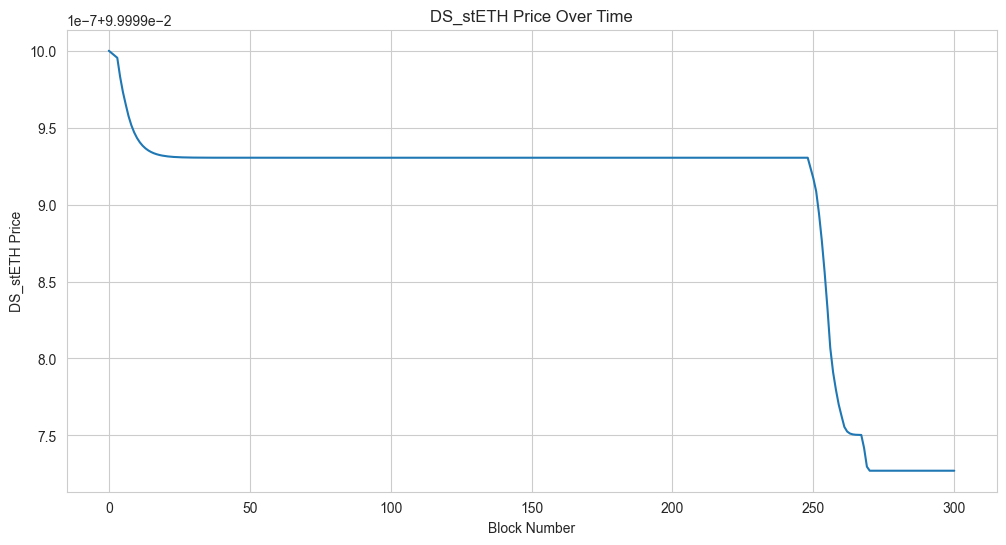

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=tokens_stats.query("token == 'DS_stETH'"),
    x='block',
    y='price'
    )
plt.title('DS_stETH Price Over Time')
plt.xlabel('Block Number')
plt.ylabel('DS_stETH Price')
plt.grid(True)
plt.show()

### AMM Reserves Over Time

#### Total ETH Reserve in AMMs


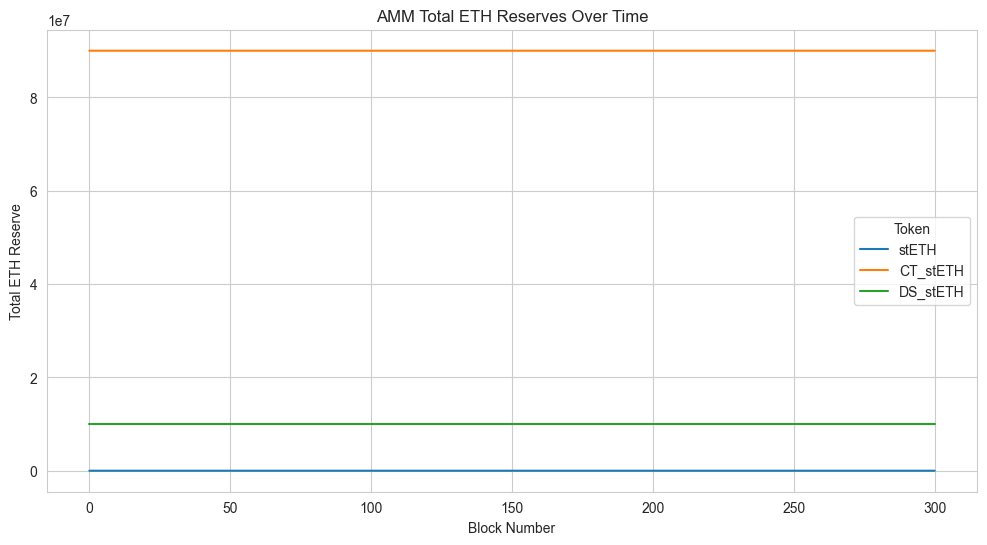

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=amms_stats,
    x='block',
    y='total_eth_reserve',
    hue='token',
)
plt.title('AMM Total ETH Reserves Over Time')
plt.xlabel('Block Number')
plt.ylabel('Total ETH Reserve')
plt.legend(title='Token')
plt.grid(True)
plt.show()


#### Total Token Reserve in AMMs


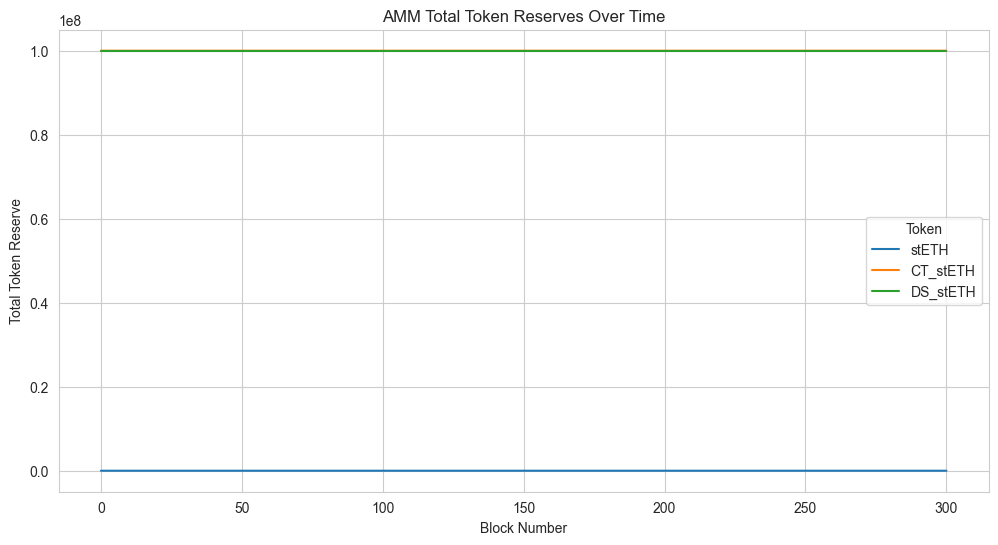

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=amms_stats,
    x='block',
    y='total_token_reserve',
    hue='token',
)
plt.title('AMM Total Token Reserves Over Time')
plt.xlabel('Block Number')
plt.ylabel('Total Token Reserve')
plt.legend(title='Token')
plt.grid(True)
plt.show()

In [14]:
amms_stats.query("token == 'DS_stETH'").head()

,block,token,total_lpt_supply,total_eth_reserve,total_token_reserve
2,0,DS_stETH,0,1.000000e+07,1.000000e+08
5,1,DS_stETH,0,1.000000e+07,1.000000e+08
8,2,DS_stETH,0,1.000000e+07,1.000000e+08
11,3,DS_stETH,0,1.000000e+07,1.000000e+08
14,4,DS_stETH,0,9.999999e+06,1.000000e+08


### Borrowed ETH Over Time

Visualize the amount of ETH borrowed over time.


In [12]:
if not borrowed_eth_stats.empty:
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=borrowed_eth_stats,
        x='block',
        y='amount',
        hue='wallet',
    )
    plt.title('Borrowed ETH Over Time')
    plt.xlabel('Block Number')
    plt.ylabel('Amount of ETH')
    plt.legend(title='Wallet')
    plt.grid(True)
    plt.show()
else:
    print("No ETH was borrowed during the simulation.")


No ETH was borrowed during the simulation.


### Borrowed Tokens Over Time

Visualize the amount of tokens borrowed over time.


In [13]:
if not borrowed_tokens_stats.empty:
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=borrowed_tokens_stats,
        x='block',
        y='amount',
        hue='token',
        style='wallet',
        markers=True,
        dashes=False
    )
    plt.title('Borrowed Tokens Over Time')
    plt.xlabel('Block Number')
    plt.ylabel('Amount of Tokens')
    plt.legend(title='Token')
    plt.grid(True)
    plt.show()
else:
    print("No tokens were borrowed during the simulation.")


No tokens were borrowed during the simulation.


## Conclusion

This notebook provides a comprehensive simulation of a cork environment with agents and tokens. By adjusting the parameters and observing the visualizations, you can gain insights into how different factors influence the blockchain dynamics.

**Possible Extensions:**

- **Add More Agents:** Implement additional agent types with different behaviors.
- **Include More Tokens:** Simulate multiple tokens interacting in the same environment.
- **Complex Strategies:** Explore more complex trading and investment strategies.

**Thank you for exploring this simulation! Feel free to modify the parameters and extend the notebook to suit your interests.**
